# Background

- The platform has 6 years worth of data.
- Problem: Issues with retention, reengagement, campaign targeting, and lack of general understanding of the user base
- Ask: How to group players based on recent behavior, general purchase behavior, and extreme purchase behavior

# Data Profile

- Business domain: scheduling platform for services
- Snapshot date: 2022-09-03
- Disclaimer: Data is private and have been masked. It will not be shared.

# Setup

In [1]:
%pip install ../.

Processing c:\users\franc\git-repo\scheduling-platform-segmentation
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for scheduling-platform-segmentation: filename=scheduling_platform_segmentation-0.0.1-py3-none-any.whl size=4980 sha256=82aeeeb14eaad8a6507e8a7b8fcb36caf38b446595731353ba76b6b51d981655
  Stored in directory: c:\users\franc\appdata\local\pip\cache\wheels\0f\b0\cc\22072402b1c65edb72b7efff9548c7464e42d8420b35ab478b
Successfully built scheduling-platform-segmentation
  Attempting uninstall: scheduling-platform-segmentation
    Found existing installation: scheduling-platform-segmentation 0.0.1
    Uninstalling scheduling-platform-segmentation-0.0.1:
      Successfully uninstalled scheduling-platform-segmentation-0.0.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import kneed
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, OPTICS, BisectingKMeans
from sklearn.neighbors import NearestNeighbors

from scheduling_platform_segmentation.constants import (
    QUANTILE_LIST, 
    TRAD_RF_SEGMENTS_LIST, 
    TRAD_RF_SEGMENTS_COLOR_DICT
    )
from scheduling_platform_segmentation.preprocess.rfm import (
    generate_quantile_dictionary,
    generate_conditions,
    generate_trad_rf_segments
)

from scheduling_platform_segmentation.plotting import plot_segments_xyz_scatter

import warnings
warnings.filterwarnings("ignore")

In [3]:
pdf_raw_user_by_vendor_by_store = pd.read_csv('user_data_by_vendor_by_store.csv')
pdf_raw_user_by_vendor_by_store = pdf_raw_user_by_vendor_by_store[[c for c in pdf_raw_user_by_vendor_by_store.columns if c != 'Unnamed: 0']]
pdf_raw_user_by_vendor_by_store['store_total_dollar_spend'] = pdf_raw_user_by_vendor_by_store['store_total_dollar_spend'] / 55.74 # foreign curr to usd conversion

pdf_raw_user_by_vendor_by_store

,user_id,install_date,vendor_id,store_id,tenure,store_days_since_last_transaction,store_num_transactions,store_total_dollar_spend
0,142488,2022-07-23,195,269,41.737250,12.899776,2,276.282741
1,133793,2022-06-01,195,269,93.859821,20.668556,3,592.034446
2,139901,2022-07-09,195,269,55.806231,55.806223,1,592.034446
3,134030,2022-06-02,195,269,92.660766,63.704679,3,351.632580
4,140978,2022-07-14,195,269,50.750846,23.745670,3,240.401866
...,...,...,...,...,...,...,...,...
92250,110297,2021-11-29,139,219,277.861396,81.845761,2,902.404019
92251,108382,2021-11-15,139,219,291.649244,88.853760,2,1062.002153
92252,123325,2022-03-22,139,219,164.875360,95.752685,1,1202.906351
92253,17108,2018-08-22,146,226,1472.914944,415.731643,1,8.970219


In [4]:
# pdf_raw_user_purchase_behavior = pd.read_csv('user_data_purchase_behavior.csv')
# pdf_raw_user_purchase_behavior = pdf_raw_user_purchase_behavior[[c for c in pdf_raw_user_purchase_behavior.columns if c != 'Unnamed: 0']]
# pdf_raw_user_purchase_behavior

# Recent Purchase Behavior

In [5]:
pdf_raw_user_by_vendor_by_store

,user_id,install_date,vendor_id,store_id,tenure,store_days_since_last_transaction,store_num_transactions,store_total_dollar_spend
0,142488,2022-07-23,195,269,41.737250,12.899776,2,276.282741
1,133793,2022-06-01,195,269,93.859821,20.668556,3,592.034446
2,139901,2022-07-09,195,269,55.806231,55.806223,1,592.034446
3,134030,2022-06-02,195,269,92.660766,63.704679,3,351.632580
4,140978,2022-07-14,195,269,50.750846,23.745670,3,240.401866
...,...,...,...,...,...,...,...,...
92250,110297,2021-11-29,139,219,277.861396,81.845761,2,902.404019
92251,108382,2021-11-15,139,219,291.649244,88.853760,2,1062.002153
92252,123325,2022-03-22,139,219,164.875360,95.752685,1,1202.906351
92253,17108,2018-08-22,146,226,1472.914944,415.731643,1,8.970219


In [6]:
pdf_user_level = (
    pdf_raw_user_by_vendor_by_store
    .groupby('user_id')
    .agg(install_date=('install_date', 'min'),
         cnt_vendors=('vendor_id', 'nunique'),
         tenure=('tenure', 'max'),
         recency=('store_days_since_last_transaction', 'min'),
         frequency=('store_num_transactions', 'sum'),
         monetary=('store_total_dollar_spend', 'sum')
         )
    )

In [7]:
dict_quantile = generate_quantile_dictionary(pdf_user_level, QUANTILE_LIST) # save this into database

pdf_rfm_scored = deepcopy(pdf_user_level)
for metric in dict_quantile.keys():
    if metric in ('recency'):
        reverse = 1
    else:
        reverse = 0

    conditions, values = generate_conditions(pdf_rfm_scored, dict_quantile, metric, reverse=reverse)
    pdf_rfm_scored[metric[0]] = np.select(conditions, values)

In [8]:
pdf_rfm_labeled = generate_trad_rf_segments(pdf_rfm_scored)
pdf_rfm_labeled

,install_date,cnt_vendors,tenure,recency,frequency,monetary,t,r,f,m,wtd_rfm
106246,2021-10-30,1,307.799153,121.934572,6,1621.743811,1,5,5,5,champions
106247,2021-10-30,1,307.797483,139.782477,1,68.640115,1,5,1,5,new_customers
106251,2021-10-30,1,307.784611,307.784600,1,767.850736,1,4,1,5,promising
106252,2021-10-30,1,307.776173,223.626908,2,26.820954,1,4,4,4,loyal_customers
106254,2021-10-30,1,307.769778,117.760101,2,26.838895,1,5,4,4,champions
...,...,...,...,...,...,...,...,...,...,...,...
34853,2019-03-09,1,1273.808965,985.000000,4,31.306064,5,2,5,4,cant_lose
34854,2019-03-09,1,1273.799046,1080.489532,2,14.172946,5,2,4,3,at_risk
34855,2019-03-09,1,1273.781311,1147.726193,1,8.073197,5,1,1,2,hibernating
34856,2019-03-09,1,1273.769372,1084.455102,2,15.159670,5,2,4,4,at_risk


In [9]:
pdf_summary = (
    pdf_rfm_labeled
    .groupby(['wtd_rfm', 't'])
    .describe()[[('tenure', 'count'), 
                ('recency', 'mean'), #('recency', '50%'), 
                ('frequency', 'mean'), #('frequency', '50%'), 
                ('monetary', 'mean'), #('monetary', '50%')
                ]]
    .reset_index()
    )

pdf_summary.columns = ['segment', 'tenure', 'cnt_users', 
                       'recency_mean', #'recency_median', 
                       'frequency_mean', #'frequency_median', 
                       'monetary_mean', #'monetary_median'
                       ]

pdf_summary = pdf_summary.sort_values(['tenure', 'segment']).set_index(['tenure', 'segment'])
pdf_summary

cnt_users  recency_mean  frequency_mean  monetary_mean
tenure segment                                                                
1      champions           2397.0     67.300643        2.786400     138.536116
       loyal_customers      209.0    235.982359        2.157895     123.256301
       new_customers      11088.0     91.972988        1.000000      39.850390
       promising           3713.0    251.336164        1.000000      41.149131
2      about_to_sleep      5486.0    653.309957        1.000000       4.565450
       champions           1556.0     77.952291        4.016067     174.754258
       loyal_customers     2138.0    487.562068        2.624415      35.731676
       new_customers        284.0     96.500293        1.000000      58.531815
       promising           7943.0    509.049597        1.000000      17.305547
3      about_to_sleep      8148.0    730.733086        1.000000       4.475981
       at_risk              294.0    907.107625        2.000000      21.984969
       cant_lose            100.0    907.391520        3.490000      38.224794
       champions            277.0     69.286398        7.447653      88.065334
       hibernating         3993.0    851.489779        1.000000       6.598053
       loyal_customers     4546.0    639.024032        3.078311      14.715538
       new_customers          9.0    108.985974        1.000000      28.800383
       promising             39.0    467.649378        1.000000       9.809739
4      about_to_sleep        19.0    697.432204        1.000000       9.678394
       at_risk             2613.0   1061.832526        2.000000      21.127780
       cant_lose           3008.0   1001.462601        5.272939      58.357609
       champions            562.0     72.270062       13.186833     135.868122
       hibernating        10243.0   1122.149329        1.000000      10.379778
       loyal_customers      926.0    538.295299        5.855292      53.957823
       new_customers         11.0    119.471380        1.000000      11.641713
       promising             25.0    425.968545        1.000000      11.255113
5      about_to_sleep        36.0    710.145694        1.000000       9.590659
       at_risk             2526.0   1363.040907        2.000000      18.024662
       cant_lose           4967.0   1170.440644       14.039058      89.694417
       champions           1160.0     73.786930       15.587069     144.855378
       hibernating         7070.0   1495.983133        1.000000       9.869117
       loyal_customers     1507.0    498.482375       10.832780      94.080560
       new_customers         63.0    102.099446        1.000000      11.677232
       promising             78.0    378.118750        1.000000      11.452439

# ML-based clustering

In [10]:
# preprocess
pdf_gen = deepcopy(pdf_rfm_labeled)
pdf_gen['avg_txn_amount'] = pdf_gen['monetary'] / pdf_gen['frequency']
pdf_gen['cnt_vendors'] = pdf_gen['cnt_vendors'].astype(int)
pdf_gen_feat = pdf_gen[['cnt_vendors', 'tenure', 'recency', 'frequency', 'monetary', 'avg_txn_amount']]

# data transformation
pdf_gen_log = np.log1p(pdf_gen_feat)

In [12]:
# scale and finalize preprocessing
scaler = StandardScaler()
scaler.fit(pdf_gen_log)
arr_processed = scaler.transform(pdf_gen_log)
pdf_processed = pd.DataFrame(arr_processed, columns=pdf_gen_log.columns, index=pdf_gen_log.index)
pdf_processed.head()

,cnt_vendors,tenure,recency,frequency,monetary,avg_txn_amount
106246,-0.106311,-0.667728,-1.155880,1.854235,4.509947,4.320630
106247,-0.106311,-0.667734,-1.040042,-0.545884,1.522156,2.570603
106251,-0.106311,-0.667775,-0.368904,-0.545884,3.801106,5.661229
106252,-0.106311,-0.667802,-0.640805,0.230931,0.651448,0.543198
106254,-0.106311,-0.667823,-1.185400,0.230931,0.652060,0.543999


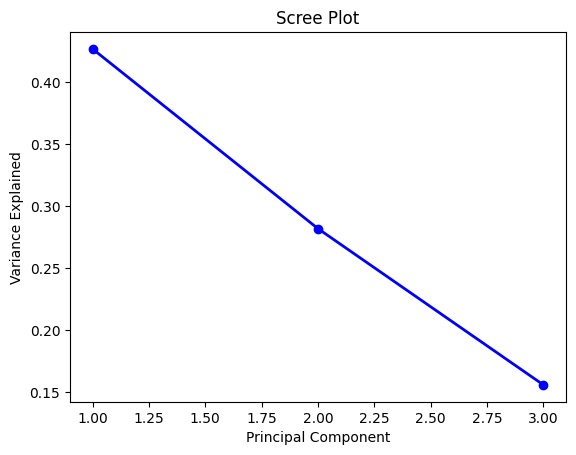

In [13]:
#define PCA model to use
pca = PCA(n_components=3)

#fit PCA model to data
pca_fit = pca.fit(pdf_processed)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [14]:
#define PCA model to use
pca = PCA(n_components=2)

#fit PCA model to data
pca_fit_transformed = pca.fit_transform(pdf_processed)

# General Purchase Behavior

Uses KMeans to get the average general behavior of users

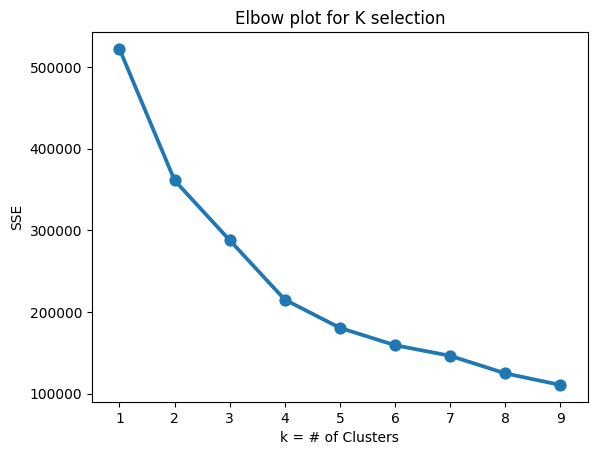

Knee:  4


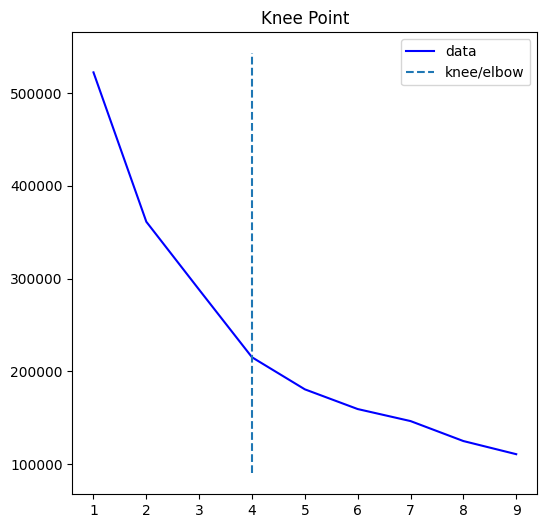

In [15]:
# k=4
sse = {}
for k in range(1,10):
    model_clustering = BisectingKMeans(n_clusters=k, random_state=100)
    model_clustering.fit(pdf_processed)
    sse[k] = model_clustering.inertia_

plt.title('Elbow plot for K selection')
plt.xlabel('k = # of Clusters')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()),
                y=list(sse.values()))
plt.show()

kneedle = kneed.KneeLocator(x=list(sse.keys()), y=list(sse.values()), curve='convex', direction='decreasing')
knee_point = kneedle.knee #elbow_point = kneedle.elbow
print('Knee: ', knee_point) #print('Elbow: ', elbow_point)
kneedle.plot_knee()

In [16]:
# centroid based clustering
k = 4
model_clustering = BisectingKMeans(n_clusters=k, random_state=100)
model_clustering.fit(pca_fit_transformed)

BisectingKMeans(n_clusters=4, random_state=100)

# Extreme Purchase Behavior

Uses DBScan to get extreme behavior that deviates from general population

In [17]:
# Find best EPS and min_sample
nn = NearestNeighbors(n_neighbors=20).fit(pdf_gen_log)
distances, indices = nn.kneighbors(pdf_gen_log)

In [18]:
# density based clustering
min_samples = 9
eps=0.25
model_clustering_DBSCAN = DBSCAN(min_samples=min_samples, eps=eps, n_jobs=-1)
model_clustering_DBSCAN.fit(pca_fit_transformed)

DBSCAN(eps=0.25, min_samples=9, n_jobs=-1)

# Combine Labels

In [19]:
pdf_clustered = pd.concat(
    [pdf_gen.reset_index(), pd.DataFrame(pca_fit_transformed, columns=['component1', 'component2'])], axis=1
)
pdf_clustered['density_clusters'] = model_clustering_DBSCAN.labels_
pdf_clustered['centroid_clusters'] = model_clustering.labels_
pdf_clustered = pdf_clustered.rename({'index': 'user_id'}, axis=1)
pdf_clustered.head()

,user_id,install_date,cnt_vendors,tenure,recency,frequency,monetary,t,r,f,m,wtd_rfm,avg_txn_amount,component1,component2,density_clusters,centroid_clusters
0,106246,2021-10-30,1,307.799153,121.934572,6,1621.743811,1,5,5,5,champions,270.290635,5.685016,2.384497,0,3
1,106247,2021-10-30,1,307.797483,139.782477,1,68.640115,1,5,1,5,new_customers,68.640115,2.770786,-0.381228,0,2
2,106251,2021-10-30,1,307.784611,307.784600,1,767.850736,1,4,1,5,promising,767.850736,5.173752,0.789162,0,3
3,106252,2021-10-30,1,307.776173,223.626908,2,26.820954,1,4,4,4,loyal_customers,13.410477,1.229250,-0.143361,0,2
4,106254,2021-10-30,1,307.769778,117.760101,2,26.838895,1,5,4,4,champions,13.419447,1.505481,-0.302994,0,2


In [20]:
(
    pdf_clustered
    .groupby('density_clusters')
    .describe()[[('user_id', 'count'),
                 ('cnt_vendors', 'mean'),
                 ('tenure', 'mean'),
                 ('recency', 'mean'),
                 ('frequency', 'mean'),
                 ('monetary', 'mean'),
                 ('avg_txn_amount', 'mean'),
                 ]]
    )

,user_id,cnt_vendors,tenure,recency,frequency,monetary,avg_txn_amount
,count,mean,mean,mean,mean,mean,mean
density_clusters,,,,,,,
-1,314.0,1.538217,738.110900,247.057799,145.226115,1339.293027,177.467332
0,86671.0,1.009461,835.369350,716.725631,2.210670,29.393162,15.851505
1,16.0,2.000000,351.001724,93.546186,6.687500,559.930032,105.290686
2,8.0,1.000000,34.654383,30.538629,1.000000,516.953714,516.953714
3,11.0,1.000000,3.265437,3.265384,1.000000,31.575170,31.575170
4,14.0,1.000000,1094.454320,1094.453373,1.000000,1.768415,1.768415


In [21]:
(
    pdf_clustered
    .groupby('centroid_clusters')
    .describe()[[('user_id', 'count'),
                 ('cnt_vendors', 'mean'),
                 ('tenure', 'mean'),
                 ('recency', 'mean'),
                 ('frequency', 'mean'),
                 ('monetary', 'mean'),
                 ('avg_txn_amount', 'mean'),
                 ]]
    )

,user_id,cnt_vendors,tenure,recency,frequency,monetary,avg_txn_amount
,count,mean,mean,mean,mean,mean,mean
centroid_clusters,,,,,,,
0,51485.0,1.000000,935.607196,896.582285,1.225774,7.332615,6.193476
1,13590.0,1.014790,1338.721027,944.877781,7.298970,58.630963,10.991059
2,17365.0,1.000000,176.192714,136.017910,1.198906,24.476044,21.470976
3,4594.0,1.175011,703.694725,185.159690,11.802569,300.870351,129.451421


# Cluster Analysis
## Composition

<AxesSubplot:xlabel='centroid_clusters', ylabel='density_clusters'>

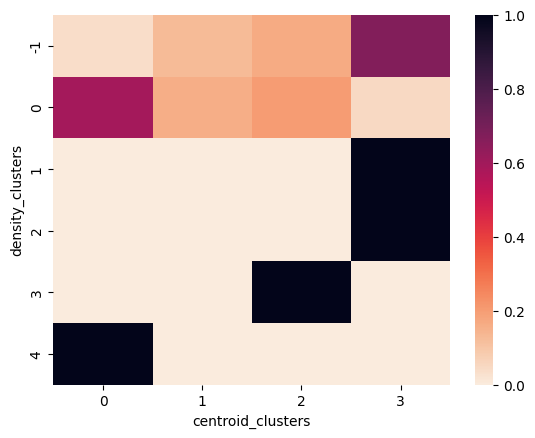

In [22]:
pdf_cluster_composition = pdf_clustered.groupby(['centroid_clusters', 'density_clusters']).agg(
    cnt_users=('user_id', 'nunique')
)
pdf_cluster_composition['cohort_size'] = pdf_cluster_composition.groupby('density_clusters')['cnt_users'].transform(
    'sum'
)
pdf_cluster_composition['pct_of_cluster'] = pdf_cluster_composition['cnt_users'] / pdf_cluster_composition['cohort_size']
cmap = sns.cm.rocket_r
sns.heatmap(pdf_cluster_composition.unstack('centroid_clusters', fill_value=0)['pct_of_cluster'], cmap=cmap)


<AxesSubplot:xlabel='centroid_clusters', ylabel='wtd_rfm'>

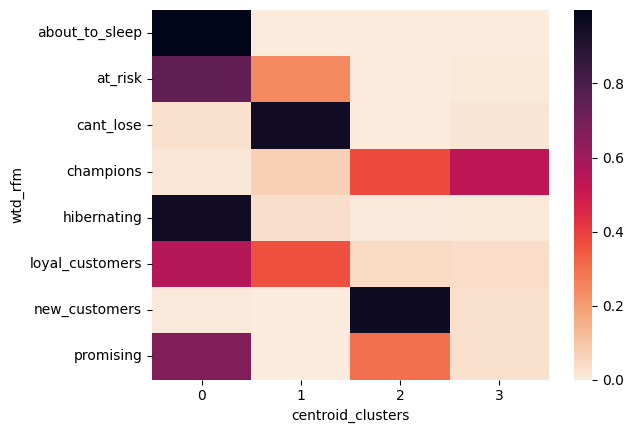

In [23]:
pdf_cluster_composition = pdf_clustered.groupby(['centroid_clusters', 'wtd_rfm']).agg(
    cnt_users=('user_id', 'nunique')
)
pdf_cluster_composition['cohort_size'] = pdf_cluster_composition.groupby('wtd_rfm')['cnt_users'].transform(
    'sum'
)
pdf_cluster_composition['pct_of_cluster'] = pdf_cluster_composition['cnt_users'] / pdf_cluster_composition['cohort_size']
cmap = sns.cm.rocket_r
sns.heatmap(pdf_cluster_composition.unstack('centroid_clusters', fill_value=0)['pct_of_cluster'], cmap=cmap)


<AxesSubplot:xlabel='density_clusters', ylabel='wtd_rfm'>

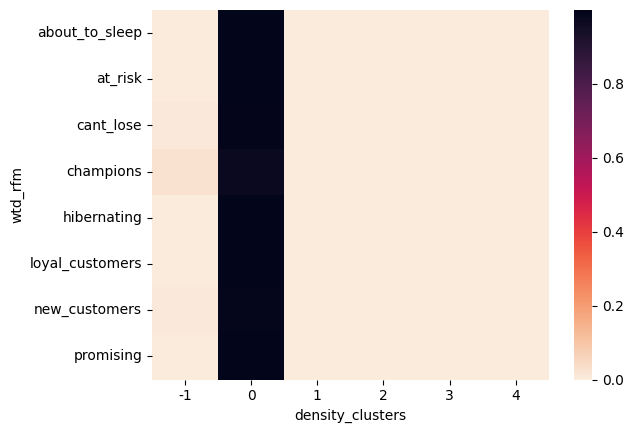

In [24]:
pdf_cluster_composition = pdf_clustered.groupby(['density_clusters', 'wtd_rfm']).agg(
    cnt_users=('user_id', 'nunique')
)
pdf_cluster_composition['cohort_size'] = pdf_cluster_composition.groupby('wtd_rfm')['cnt_users'].transform(
    'sum'
)
pdf_cluster_composition['pct_of_cluster'] = pdf_cluster_composition['cnt_users'] / pdf_cluster_composition['cohort_size']
cmap = sns.cm.rocket_r
sns.heatmap(pdf_cluster_composition.unstack('density_clusters', fill_value=0)['pct_of_cluster'], cmap=cmap)


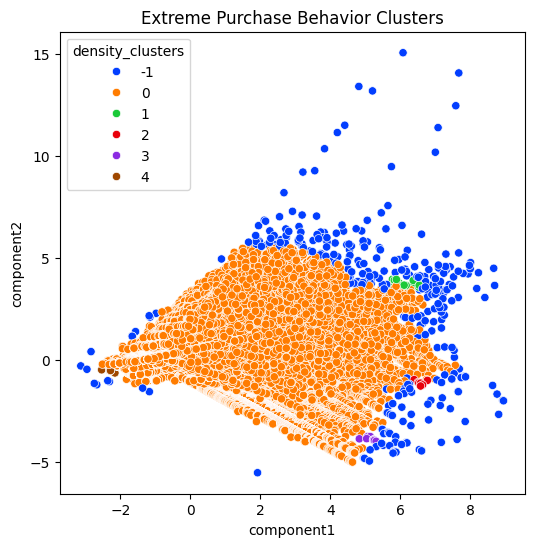

In [31]:
plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=pdf_clustered,
    x='component1', 
    y='component2', 
    hue='density_clusters', 
    palette='bright'
).set_title('Extreme Purchase Behavior Clusters')
plt.show()


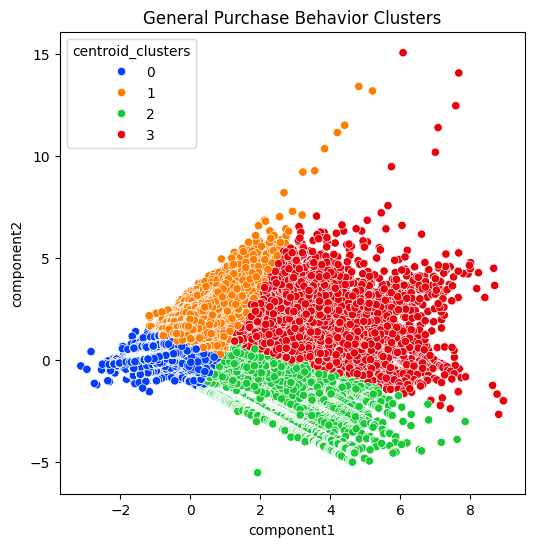

In [30]:
plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=pdf_clustered,
    x='component1', 
    y='component2', 
    hue='centroid_clusters', 
    palette='bright'
).set_title('General Purchase Behavior Clusters')
plt.show()


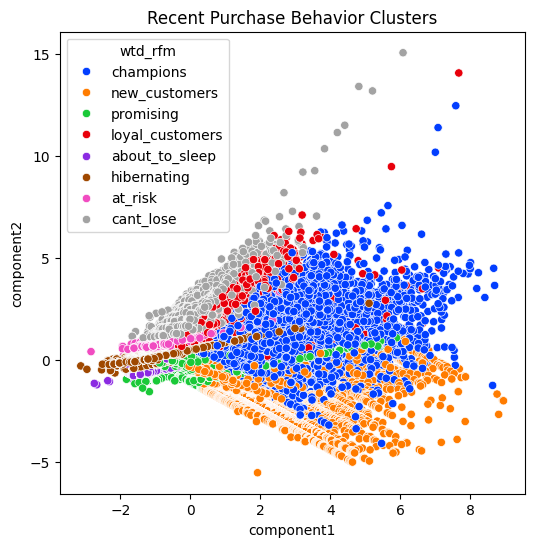

In [27]:
plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=pdf_clustered,
    x='component1', 
    y='component2', 
    hue='wtd_rfm', 
    palette='bright'
).set_title('Recent Purchase Behavior Clusters')
plt.show()


In [28]:
pdf_clustered['rfm_colors'] = pdf_clustered['wtd_rfm'].map(TRAD_RF_SEGMENTS_COLOR_DICT)

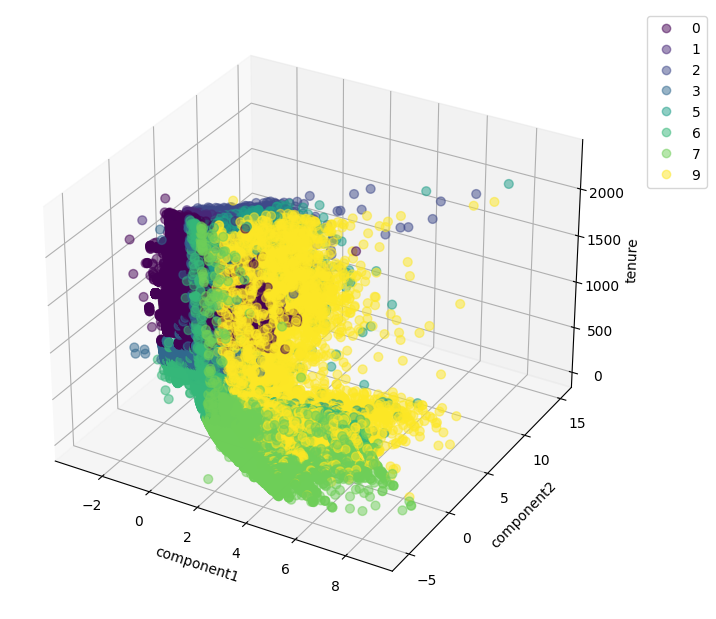

In [29]:
plot_segments_xyz_scatter(pdf_clustered, 'component1', 'component2', 'tenure', 'rfm_colors', alpha=0.5, figsize=(6, 6))